In [37]:
%reload_ext autoreload
%autoreload 2

import json
import pickle
import pandas as pd
import numpy as np
from lib import utils
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'times new roman'
plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = True

In [3]:
df = pd.read_csv('valid_sequence_data.csv',index_col=0)
df['total_money_heuristic'] = df['value_surplus'] == 60
(df.groupby('worker_id')['total_money_heuristic'].sum() >= 12).sum()

62

In [4]:
with open('bootstrap_rlm_fe_label_k.pkl', 'rb') as file:
    bootstrap_rlm_fe_label_k = pickle.load(file)

print(bootstrap_rlm_fe_label_k.conf_int())
print('M-W Criterion:',bootstrap_rlm_fe_label_k.muller_welsh_criterion())

                    median_coef        se       mad   ci_lower   ci_upper
const                 52.037295  0.625276  0.381272  50.950359  53.414325
front_amount_6m_0     -0.016828  0.002253  0.001517  -0.021194  -0.012561
front_amount_12m_0    -0.021499  0.002290  0.001554  -0.025676  -0.016800
front_amount_6m_1     -0.000712  0.000613  0.000437  -0.001879   0.000454
front_amount_12m_1    -0.000919  0.000612  0.000408  -0.002155   0.000255
choice_peli            2.480300  0.689064  0.431866   0.879837   3.663456
M-W Criterion: 122.18324049920186


In [5]:
with open('bootstrap_rlm_fe_label.pkl', 'rb') as file:
    bootstrap_rlm_fe_label_gm = pickle.load(file)

print(bootstrap_rlm_fe_label_gm.conf_int())
print('M-W Criterion:',bootstrap_rlm_fe_label_gm.muller_welsh_criterion())

                    median_coef        se       mad   ci_lower   ci_upper
const                 51.597495  0.575344  0.365516  50.548243  52.743395
front_amount_6m_0     -0.009036  0.001353  0.000874  -0.011724  -0.006411
front_amount_12m_0    -0.011782  0.001413  0.000923  -0.014636  -0.009045
front_amount_6m_1      0.000541  0.000565  0.000386  -0.000611   0.001641
front_amount_12m_1     0.000742  0.000537  0.000376  -0.000308   0.001776
choice_peli            2.694854  0.642191  0.426026   1.492297   4.004999
M-W Criterion: 125.76683295705983


In [45]:
with open('bootstrap_rlm_fe_baseline_k.pkl', 'rb') as file:
    bootstrap_rlm_fe_baseline_k = pickle.load(file)

print(bootstrap_rlm_fe_baseline_k.conf_int())
print('M-W Criterion:',bootstrap_rlm_fe_baseline_k.muller_welsh_criterion())

                  median_coef        se       mad   ci_lower   ci_upper
const               51.619849  0.598339  0.374734  50.549524  52.824301
front_amount_6m     -0.004382  0.000754  0.000509  -0.005870  -0.002897
front_amount_12m    -0.005661  0.000800  0.000536  -0.007342  -0.004210
choice_peli          2.354568  0.647736  0.399835   1.031708   3.573726
M-W Criterion: 128.45698448371468


In [7]:
with open('bootstrap_rlm_fe_baseline.pkl', 'rb') as file:
    bootstrap_rlm_fe_baseline_gm = pickle.load(file)

print(bootstrap_rlm_fe_baseline_gm.conf_int())
print('M-W Criterion:',bootstrap_rlm_fe_baseline_gm.muller_welsh_criterion())

                  median_coef        se       mad   ci_lower   ci_upper
const               51.658136  0.627373  0.392313  50.483062  53.055173
front_amount_6m     -0.004406  0.000783  0.000531  -0.006070  -0.002942
front_amount_12m    -0.005718  0.000796  0.000537  -0.007345  -0.004221
choice_peli          2.325110  0.679582  0.435810   0.971769   3.710583
M-W Criterion: 128.47548136846734


In [8]:
with open('bootstrap_rlm_pool_label_k.pkl', 'rb') as file:
    bootstrap_rlm_pool_label_k = pickle.load(file)

print(bootstrap_rlm_pool_label_k.conf_int())
print('M-W Criterion:',bootstrap_rlm_pool_label_k.muller_welsh_criterion())

                    median_coef        se       mad   ci_lower   ci_upper
const                 57.495463  0.621453  0.434982  56.298747  58.645625
front_amount_6m_0     -0.065220  0.003300  0.002146  -0.071808  -0.058728
front_amount_12m_0    -0.068312  0.003036  0.001987  -0.074383  -0.062169
front_amount_6m_1      0.009657  0.001413  0.000961   0.007095   0.012658
front_amount_12m_1     0.009002  0.001521  0.001046   0.006023   0.011987
choice_peli           -1.362942  0.532011  0.352872  -2.409226  -0.311968
M-W Criterion: 233.49339736820806


In [9]:
with open('bootstrap_rlm_pool_label.pkl', 'rb') as file:
    bootstrap_rlm_pool_label_gm = pickle.load(file)

print(bootstrap_rlm_pool_label_gm.conf_int())
print('M-W Criterion:',bootstrap_rlm_pool_label_gm.muller_welsh_criterion())

                    median_coef        se       mad   ci_lower   ci_upper
const                 56.466645  0.784845  0.533973  54.892232  57.889864
front_amount_6m_0     -0.025179  0.002782  0.001766  -0.030860  -0.019785
front_amount_12m_0    -0.028759  0.002939  0.002043  -0.034487  -0.023168
front_amount_6m_1      0.013115  0.001693  0.001124   0.010050   0.016607
front_amount_12m_1     0.013226  0.001591  0.001075   0.010217   0.016490
choice_peli           -0.106409  0.715483  0.470609  -1.546472   1.246396
M-W Criterion: 356.8011617864081


In [10]:
with open('bootstrap_rlm_pool_baseline_k.pkl', 'rb') as file:
    bootstrap_rlm_pool_baseline_k = pickle.load(file)

print(bootstrap_rlm_pool_baseline_k.conf_int())
print('M-W Criterion:',bootstrap_rlm_pool_baseline_k.muller_welsh_criterion())

                  median_coef        se       mad   ci_lower   ci_upper
const               57.124822  0.863202  0.579563  55.328662  58.808239
front_amount_6m     -0.002620  0.002060  0.001344  -0.006633   0.001352
front_amount_12m    -0.003855  0.002100  0.001432  -0.008180   0.000193
choice_peli         -2.219607  0.792939  0.521845  -3.792836  -0.664388
M-W Criterion: 427.48249228425016


In [11]:
with open('bootstrap_rlm_pool_baseline.pkl', 'rb') as file:
    bootstrap_rlm_pool_baseline_gm = pickle.load(file)

print(bootstrap_rlm_pool_baseline_gm.conf_int())
print('M-W Criterion:',bootstrap_rlm_pool_baseline_gm.muller_welsh_criterion())

                  median_coef        se       mad   ci_lower   ci_upper
const               57.101185  0.887055  0.588957  55.301130  58.755019
front_amount_6m     -0.002627  0.002039  0.001364  -0.006644   0.001328
front_amount_12m    -0.003934  0.002085  0.001383  -0.008101   0.000183
choice_peli         -2.230786  0.800106  0.529479  -3.738779  -0.620995
M-W Criterion: 427.4926733136112


In [68]:
# Make regression tables
# load the regression results
with open('model_reg_result_k.json', 'r') as f:
    reg_result = json.load(f)

# some OLS results contain the 'Intercept' term
# replace it by 'const' 
for m in list(reg_result.keys()):
    if 'Intercept' in reg_result[m]['coef_name']:
        index_to_replace = reg_result[m]['coef_name'].index('Intercept')
        reg_result[m]['coef_name'][index_to_replace] = 'const'

# column names for the dataframe
indicators = ['nobs','rsquared_adj']
col_name_list = ['b_front_amount_6m','se_front_amount_6m',
                'b_front_amount_12m','se_front_amount_12m',
                'b_front_amount_6m_0','se_front_amount_6m_0',
                'b_front_amount_12m_0','se_front_amount_12m_0',
                'b_front_amount_6m_1','se_front_amount_6m_1',
                'b_front_amount_12m_1','se_front_amount_12m_1',
                'b_choice_peli','se_choice_peli',
                'b_const','se_const'] 

col_names = col_name_list + indicators

# make a dataframe in which columns are specified using the column names
# each row of this dataframe is correspondent to a model 
result_table = utils.draw_df_from_result(reg_result,col_names)

# specific the indices used for table
param_list = [r'$Y_1\cdot1\{T=T_L\}$',
            '',
            r'$Y_1\cdot1\{T=T_H\}$',
            '',
            r'$Y_1\cdot1\{T=T_L\}\times$CL1',
            '',
            r'$Y_1\cdot1\{T=T_H\}\times$CL1',
            '',
            r'$Y_1\cdot1\{T=T_L\}\times$CL2',
            '',
            r'$Y_1\cdot1\{T=T_H\}\times$CL2',
            '',
            'PELI',
            '',
            'Constant',
            '',
            'observations']

# make a grand table
reg_table = pd.DataFrame(result_table.iloc[:,:-1].values.T,columns=result_table['model'])
reg_table.iloc[-1,4:] = np.repeat('',4)
reg_table.index.name = None
reg_table.columns.name = None


In [69]:
reg_table_combined = reg_table.iloc[:,[0,1,2,3,6,7]]
reg_table_combined.columns = ['(1) Pool', '(2) Pool', '(3) FE', '(4) FE','(5) RLM', '(6) RLM']
reg_table_combined.loc['muller_welsh'] = [
                    '','','','',
                    str(round(bootstrap_rlm_fe_baseline_k.muller_welsh_criterion(),3)),
                    str(round(bootstrap_rlm_fe_label_k.muller_welsh_criterion(),3))]
reg_table_combined.index = param_list + ['adj-$R^2$','Muller-Welsh']

utils.make_table(reg_table_combined,'tables/reg_combined.tex')

C:\Users\zarkwang\AppData\Local\Temp\ipykernel_4476\3144719332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_table_combined.loc['muller_welsh'] = [


In [27]:
reg_table_combined = reg_table[reg_table.columns[['_fe' in col for col in reg_table.columns]]]
reg_table_combined.columns = ['(1) OLS', '(2) OLS', '(3) RLM', '(4) RLM']
reg_table_combined.loc['muller_welsh'] = [
                    '','',
                    str(round(bootstrap_rlm_fe_baseline_k.muller_welsh_criterion(),3)),
                    str(round(bootstrap_rlm_fe_label_k.muller_welsh_criterion(),3))]
reg_table_combined.index = param_list + ['adj-$R^2$','Muller-Welsh']

utils.make_table(reg_table_combined,'tables/reg_combined.tex')

C:\Users\zarkwang\AppData\Local\Temp\ipykernel_4476\2605552774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_table_combined.loc['muller_welsh'] = [


In [28]:

# split the OLS table from the grand table
reg_table_1 = reg_table.iloc[:,:4]
reg_table_1.columns = ['(1) Pooled', '(2) Pooled', '(3) FE', '(4) FE']
reg_table_1.index = param_list + ['adj-$R^2$']

# split the RLM table from the grand table
reg_table_2 = reg_table.iloc[:-1,4:]
reg_table_2.loc['muller_welsh'] = np.round([
                    bootstrap_rlm_pool_baseline_k.muller_welsh_criterion(),
                    bootstrap_rlm_pool_label_k.muller_welsh_criterion(),
                    bootstrap_rlm_fe_baseline_k.muller_welsh_criterion(),
                    bootstrap_rlm_fe_label_k.muller_welsh_criterion()],3).astype(str)

reg_table_2.columns = ['(5) Pooled', '(6) Pooled', '(7) FE', '(8) FE']
reg_table_2.index = param_list + ['Muller-Welsh']

# write latex code
utils.make_table(reg_table_1,'tables/reg_ols.tex')
utils.make_table(reg_table_2,'tables/reg_rlm.tex')

In [29]:
# Make table for GMM results
with open('model_reg_result_gm.json', 'r') as f:
    reg_result = json.load(f)

col_names = col_name_list + ['nobs']

result_table = utils.draw_df_from_result(reg_result,col_names)

reg_table = pd.DataFrame(result_table.iloc[:,:-1].values.T,columns=result_table['model'])
reg_table.columns.name = None
reg_table.loc['muller_welsh'] = np.round([
                    bootstrap_rlm_pool_baseline_gm.muller_welsh_criterion(),
                    bootstrap_rlm_pool_label_gm.muller_welsh_criterion(),
                    bootstrap_rlm_fe_baseline_gm.muller_welsh_criterion(),
                    bootstrap_rlm_fe_label_gm.muller_welsh_criterion()],3).astype(str)

reg_table.columns = ['(5) Pooled', '(6) Pooled', '(7) FE', '(8) FE']
reg_table.index = param_list + ['Muller-Welsh']

utils.make_table(reg_table,'tables/reg_rlm_GMM.tex')

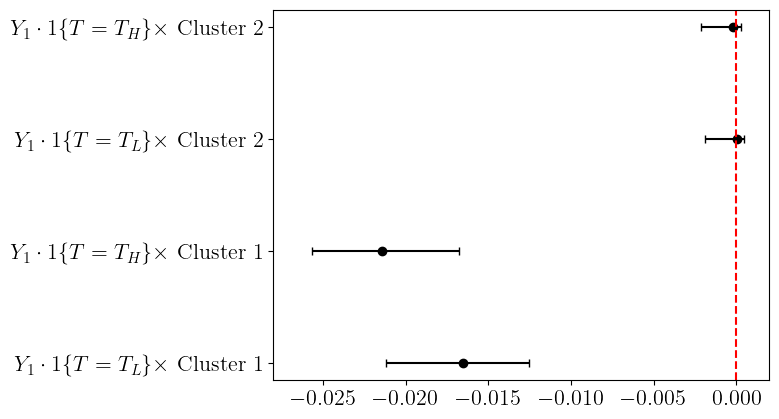

In [58]:
ci_table = bootstrap_rlm_fe_label_k.conf_int().iloc[1:,3:5]
ci_table['coef'] = bootstrap_rlm_fe_label_k.model.params[bootstrap_rlm_fe_label_k.param_names]
ci_table = ci_table.iloc[:-1,:]
plt.errorbar(x=ci_table['coef'], y=ci_table.index, 
             xerr=[ci_table['coef'] - ci_table['ci_lower'], ci_table['ci_upper'] - ci_table['coef']], 
             fmt='none', color='black',
             capsize=3)
plt.scatter(x=ci_table['coef'], y=ci_table.index, color = 'black')
plt.axvline(x = 0, color = 'red', linestyle = 'dashed')


label_param_list = [
            r'$Y_1\cdot1\{T=T_L\}\times$ Cluster 1',
            r'$Y_1\cdot1\{T=T_H\}\times$ Cluster 1',
            r'$Y_1\cdot1\{T=T_L\}\times$ Cluster 2',
            r'$Y_1\cdot1\{T=T_H\}\times$ Cluster 2'
            ]

plt.yticks(ci_table.index,label_param_list)
plt.xticks(np.arange(-0.025,0.005,step=0.005))
plt.xlim((-0.028,0.002))
plt.show()

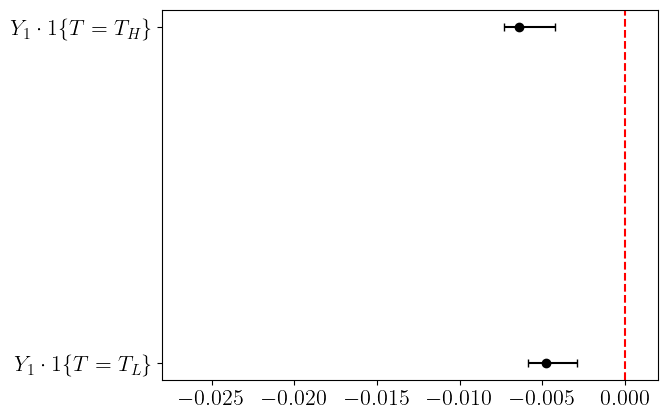

In [57]:
ci_table = bootstrap_rlm_fe_baseline_k.conf_int().iloc[1:,3:5]
ci_table['coef'] = bootstrap_rlm_fe_baseline_k.model.params[bootstrap_rlm_fe_baseline_k.param_names]
ci_table = ci_table.iloc[:-1,:]
plt.errorbar(x=ci_table['coef'], y=ci_table.index, 
             xerr=[ci_table['coef'] - ci_table['ci_lower'], ci_table['ci_upper'] - ci_table['coef']], 
             fmt='none', color='black',
             capsize=3)
plt.scatter(x=ci_table['coef'], y=ci_table.index, color = 'black')
plt.axvline(x = 0, color = 'red', linestyle = 'dashed')

label_param_list = [
            r'$Y_1\cdot1\{T=T_L\}$',
            r'$Y_1\cdot1\{T=T_H\}$'
            ]

plt.yticks(ci_table.index,label_param_list)
plt.xticks(np.arange(-0.025,0.005,step=0.005))
plt.xlim((-0.028,0.002))
plt.show()

In [54]:
np.arange(-0.025,0.001,step=0.005)

array([-2.50000000e-02, -2.00000000e-02, -1.50000000e-02, -1.00000000e-02,
       -5.00000000e-03,  3.46944695e-18])